## Calculate degree of separation for DUD-E proteins and ligands

This notebook calculates the degree of separation (and associated statistics)
for proteins and ligands stored in the PyTorch `Data` format.

In [1]:
# Delete the following:
%load_ext nb_black

<IPython.core.display.Javascript object>

In [2]:
import heapq
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from progressbar import progressbar
from torch_geometric.data import Data

<IPython.core.display.Javascript object>

### Function definitions

In [3]:
# get_distances_vertex implementation from
# https://bradfieldcs.com/algos/graphs/dijkstras-algorithm/
# Retrieved and modified on 17/12/2020.


def get_distances_vertex(graph, starting_vertex, filter_natural=True):
    """Get the shortest distances from the starting vertex to every other."""
    # Initialize all distances as infinity, except for that between the
    # starting vertex and itself.
    distances = {vertex: float("infinity") for vertex in graph}
    distances[starting_vertex] = 0

    # Initialize the priority queue with the vertex we start the path from.
    pq = [(0, starting_vertex)]
    while len(pq) > 0:
        # Pop out the "most promising" vertex to next visit.
        current_distance, current_vertex = heapq.heappop(pq)

        # Nodes can get added to the priority queue multiple times. We only
        # process a vertex the first time we remove it from the priority queue.
        if current_distance > distances[current_vertex]:
            continue

        # Consider visiting the neighbors of the current vertex in consideration.
        for neighbor, weight in graph[current_vertex].items():
            distance = current_distance + weight

            # Only consider this new path if it's better than any path we've
            # already found.
            if distance < distances[neighbor]:
                # Update the shortest distance to this neighbor.
                distances[neighbor] = distance
                heapq.heappush(pq, (distance, neighbor))

    # Filter out all infinite distance entries (i.e., the vertex isn't reachable
    # from starting_vertex), and the entry for the starting_vertex itself.
    if filter_natural:
        return {
            vertex: distance
            for vertex, distance in distances.items()
            if vertex != starting_vertex and not np.isinf(distance)
        }
    return distances


def get_distances_all(graph):
    """Get the shortest distances towards every vertex in the graph from every other."""
    all_distances = []
    for i in range(len(graph.keys())):
        all_distances.append(get_distances_vertex(graph, i))
    return all_distances

<IPython.core.display.Javascript object>

### Application: proteins

In [4]:
# Get the list of target names.
all_targets = pd.read_csv("../data/dud-e_targets.csv").target_name.tolist()
all_targets = [target.lower() for target in all_targets]

# Temporary removal -- bond information not available.
all_targets.remove("aa2ar")
all_targets.remove("drd3")

<IPython.core.display.Javascript object>

In [5]:
def get_data(target, cutoff):
    # cutoff refers to the cutoff used to filter the protein PDB.
    # More details in 00_protein_processing.ipynb.
    return pd.read_pickle(f"../data/raw/{cutoff}_{target}.pkl")


def data_to_dict(data):
    """Convert the Data to the dictionary graph representation."""
    edge_indices = data.edge_index.numpy()
    graph_dict = dict()
    # For each vertex in the graph, create a dictionary in graph_dict.
    for i in range(data.x.shape[0]):
        graph_dict[i] = dict()
    # For each edge, record it in graph_dict. In our use case,
    # the weight of each bond is "1", although this notebook can be used
    # otherwise.
    for i in range(len(edge_indices[0])):
        graph_dict[edge_indices[0][i]][edge_indices[1][i]] = 1
    return graph_dict

<IPython.core.display.Javascript object>

In [6]:
# Get the dictionary of target graph dictionaries.
all_targets_dict = dict(
    zip(all_targets, [data_to_dict(get_data(target, 10)) for target in all_targets])
)

<IPython.core.display.Javascript object>

In [21]:
# Calculate the degree of separatedness for each target graph.
protein_all_distances = dict(
    zip(
        all_targets,
        [get_distances_all(all_targets_dict[target]) for target in all_targets],
    )
)

<IPython.core.display.Javascript object>

### Application: ligands

Repeat a similar process for ligands, which are organized under the target they are tested on.

In [8]:
def load_ligands(target, sample):
    """Get the ligand graph dictionaries relating to the target."""
    target_data_dict = pd.read_pickle(f"../data/raw/{target}_ligand_dict.pkl")
    # If sampling, randomly select only
    if sample is not None:
        selected_ligands = np.random.choice(
            list(target_data_dict.keys()), size=sample, replace=False
        )
    # Repurpose data_to_dict() from the proteins section, since
    # ligands are also stored as Data objects.
    return {
        ligand_code: data_to_dict(ligand_data)
        for ligand_code, ligand_data in target_data_dict.items()
        if ligand_code in selected_ligands
    }


def get_ligand_distances(target, sample=None):
    """Get vertex-vertex shortest distances for each ligand for the target."""
    target_data_dict = load_ligands(target, sample)
    return {
        ligand_code: get_distances_all(ligand_graph_dict)
        for ligand_code, ligand_graph_dict in target_data_dict.items()
    }

<IPython.core.display.Javascript object>

In [9]:
# Get vertex-vertex shortest path distances for all ligands.
np.random.seed(1)
ligand_all_distances = dict()
for target in progressbar(all_targets):
    ligand_all_distances[target] = get_ligand_distances(target, sample=400)

100% (100 of 100) |######################| Elapsed Time: 0:11:13 Time:  0:11:13


<IPython.core.display.Javascript object>

### Descriptive statistics

##### Proteins

The below representative example shows the separatedness of vertices from each other in protein graphs, which are generally fractured. Most vertices are isolated from others. This has large implications on learnability of useful vertex representations through graph convolutional networks, and suggests the use of graph power-based methods to increase connectivity. An alternative to increase connectivity is to use a nearest-neighbor based method to determine edges. Currently, edges exist only if a chemical bond does.

In [22]:
protein_all_distances["pur2"]

[{},
 {2: 1},
 {1: 1},
 {},
 {},
 {9: 1},
 {},
 {10: 1, 11: 1},
 {12: 1, 13: 1},
 {5: 1},
 {7: 1, 11: 2},
 {7: 1, 10: 2},
 {8: 1, 13: 2},
 {8: 1, 12: 2},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {25: 1},
 {},
 {},
 {},
 {21: 1},
 {37: 1},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {26: 1},
 {46: 1},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {38: 1},
 {63: 1},
 {},
 {},
 {},
 {},
 {},
 {},
 {58: 1},
 {},
 {59: 1, 60: 1},
 {61: 1, 62: 1},
 {54: 1},
 {56: 1, 60: 2},
 {56: 1, 59: 2},
 {57: 1, 62: 2},
 {57: 1, 61: 2},
 {47: 1},
 {72: 1},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {64: 1},
 {81: 1},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {73: 1},
 {},
 {},
 {},
 {},
 {},
 {},
 {89: 1, 90: 1},
 {88: 1, 90: 2},
 {88: 1, 89: 2},
 {94: 1},
 {},
 {},
 {91: 1},
 {},
 {},
 {},
 {102: 1},
 {},
 {},
 {},
 {98: 1},
 {},
 {},
 {},
 {},
 {},
 {112: 1},
 {},
 {},
 {},
 {108: 1},
 {120: 1},
 {},
 {},
 {},
 {},
 {119: 1},
 {118: 1},
 {113: 1},
 {122: 1},
 {121: 1},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},

<IPython.core.display.Javascript object>

##### Ligands

In [14]:
def get_dos_list(distances_dict):
    return np.array([value for subdict in distances_dict for value in subdict.values()])


def get_per_ligand_mean_dos(target):
    curr_dict = ligand_all_distances[target]
    ligand_means = []
    for ligand_code in curr_dict.keys():
        ligand_means.append(get_dos_list(curr_dict[ligand_code]).mean())
    return ligand_means

<IPython.core.display.Javascript object>

In [15]:
all_per_ligand_means = []
all_per_target_means = []
for target in progressbar(all_targets):
    curr_per_ligand_mean_dos = get_per_ligand_mean_dos(target)
    all_per_ligand_means += curr_per_ligand_mean_dos
    all_per_target_means.append(np.mean(curr_per_ligand_mean_dos))

100% (100 of 100) |######################| Elapsed Time: 0:00:11 Time:  0:00:11


<IPython.core.display.Javascript object>

In [16]:
def plot_histogram(x, title):
    n, bins, patches = plt.hist(
        x=x, bins="auto", color="#0504aa", alpha=0.7, rwidth=0.85
    )
    plt.grid(axis="y", alpha=0.75)
    plt.xlabel("DoS")
    plt.ylabel("Frequency")
    plt.title(title)
    plt.axvline(x=np.mean(x), color="red", linestyle="--")
    maxfreq = n.max()
    plt.ylim(ymax=np.ceil(maxfreq / 10) * 10 if maxfreq % 10 else maxfreq + 10)

<IPython.core.display.Javascript object>

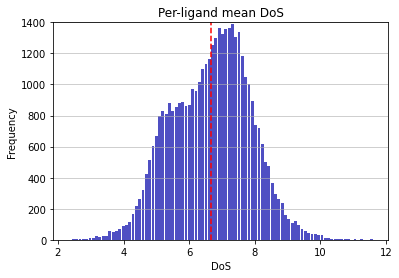

<IPython.core.display.Javascript object>

In [17]:
plot_histogram(all_per_ligand_means, "Per-ligand mean DoS")

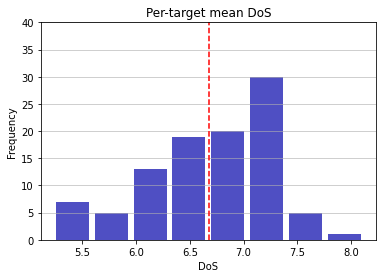

<IPython.core.display.Javascript object>

In [18]:
plot_histogram(all_per_target_means, "Per-target mean DoS")

The case with ligands differs significantly:
1. The "fracturing" seen in protein graphs does not exist for ligand graphs, and vertices are generally 6-7 "hops" from each other.
2. The separatedness of verices is consistent across targets; i.e. the ligands associated with one target do not differ significantly in their separatedness from that of other targets.